# Consulta catalogo Lansat
Planetary Computer tiene la capacidad de buscar una determinada región dentro de las imágenes satelitales disponibles y retornar dicha región recortada. El siguiente ejemplo fue adaptado del <a href=https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2#Example-Notebook>ejemplo </a> disponible en la página de la herramienta. Aquí obtendremos la lista de de imágenes que contienen nuestra región de consulta en un intervalo de fechas determinadas.

## Carga de librerías necesarias
A continuación se cargarán las librerías necesarias para poder acceder a listado de imágenes que contienen una región de interés. El listado de librerías es

In [0]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

## Definición de zona de consulta
Definimos la zona a buscar dentro del catalogo de lansat. En este caso consultaremos la zona de nuestro centro de investigación principal, Tibaitatá, en Mosquera Cundinamarca.

In [0]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-74.20191764831543,4.696793484410148],
            [-74.2129898071289,4.696023601786466],
            [-74.21968460083008,4.68661385665204],
            [-74.21350479125975,4.684304172562671],
            [-74.20372009277344,4.65898269196767],
            [-74.2020034790039,4.657870578971854],
            [-74.19608116149902,4.66163464662711],
            [-74.19831275939941,4.672156819644733],
            [-74.19719696044922,4.691147658775067],
            [-74.20148849487305,4.691917546778364],
            [-74.20191764831543,4.696793484410148]
        ]
    ],
}

Definimos un intervalo de fechas de toma de las imágenes satelitales, desde 1990 hasta el 2021.

In [0]:
time_of_interest = "1990-01-01/2021-12-31"

y obtenemos la lista de imágenes satelitales multiespectrales disponibles mediante

In [0]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 100}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 191 Items

## Seleccionar y visualizar una imagen de la lista
Seleccionaremos la imágen satelital con el mínimo de nubosidad. Esto se logra primero ordenando por porcentaje de nubosidad las imágenes disponibles y luego eligiendo el primer elemento.

In [0]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_008057_20150104_02_T1 from 2015-01-04 with 5.13% cloud cover

para este caso, tenemos un imágen con un mínimo de 5.13 por ciento de nubosidad.

## Visualización de imágen seleccionada
Para ver la imágen seleccionada, debemos usar la información disponible en el espectro visible (rojo, verde y azul). Para ello definimos una función que nos permita buscar la información asociada a este espectro.

In [0]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

Usamos esta función para obtener cada una de las bandas del espctro visible.

In [0]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "blue").href,
]

y creamos las direcciones de dichas imagenes usando nuestro login de planetary computer.

In [0]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

Para visualizar la imágen usamos la librería rasterio.

Out[17]:

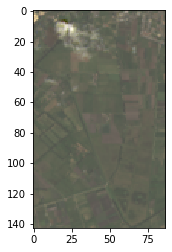

<matplotlib.image.AxesImage at 0x7f8faa84f390>

In [0]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands = [read_band(href) for href in signed_hrefs]
multiband_data = np.stack(bands)
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
img=Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

import matplotlib.pyplot as plt
plt.imshow(img)